## Kabak Fiyatlandırması için Doğrusal ve Polinomial Regresyon - Ders 3

Gerekli kütüphaneleri ve veri setini yükleyin. Verileri aşağıdaki alt küme içeren bir veri çerçevesine dönüştürün:

- Sadece kile ile fiyatlandırılan kabakları alın
- Tarihi bir aya dönüştürün
- Fiyatı, yüksek ve düşük fiyatların ortalaması olarak hesaplayın
- Fiyatı kile miktarına göre fiyatlandırmayı yansıtacak şekilde dönüştürün


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

Bir dağılım grafiği, elimizde yalnızca Ağustos'tan Aralık'a kadar olan ay verilerinin bulunduğunu hatırlatır. Muhtemelen doğrusal bir şekilde sonuçlar çıkarabilmek için daha fazla veriye ihtiyacımız var.


<AxesSubplot:xlabel='Month', ylabel='Price'>

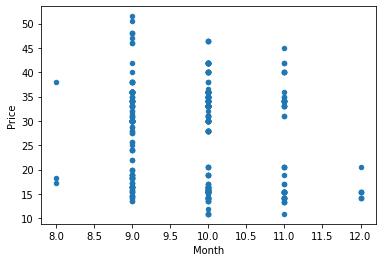

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

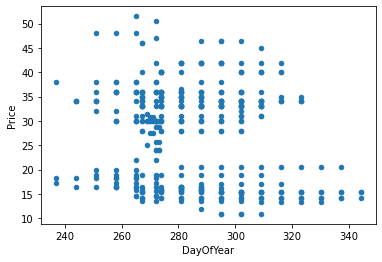

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


Görünüşe göre korelasyon oldukça küçük, ancak başka daha önemli bir ilişki var - çünkü yukarıdaki grafikteki fiyat noktaları birkaç belirgin küme oluşturuyor gibi görünüyor. Haydi farklı kabak çeşitlerini gösterecek bir grafik yapalım:


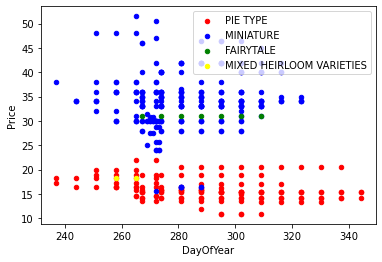

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

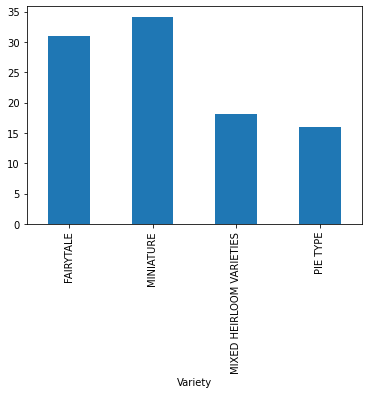

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

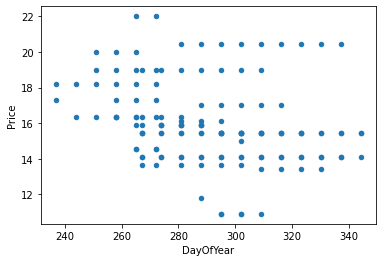

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### Doğrusal Regresyon

Doğrusal regresyon modelini eğitmek için Scikit Learn kullanacağız:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


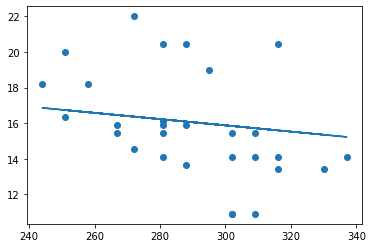

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

Doğrunun eğimi, doğrusal regresyon katsayılarından belirlenebilir:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

Eğitilmiş modeli fiyat tahmini yapmak için kullanabiliriz:


In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### Polinom Regresyon

Bazen özellikler ile sonuçlar arasındaki ilişki doğası gereği doğrusal olmayabilir. Örneğin, kabak fiyatları kış aylarında (aylar=1,2) yüksek olabilir, yaz aylarında (aylar=5-7) düşebilir ve ardından tekrar yükselebilir. Doğrusal regresyon bu ilişkiyi doğru bir şekilde bulamaz.

Bu durumda, ek özellikler eklemeyi düşünebiliriz. Basit bir yöntem, giriş özelliklerinden polinomlar kullanmaktır, bu da **polinom regresyon** ile sonuçlanır. Scikit Learn'de, polinom özelliklerini otomatik olarak önceden hesaplamak için boru hatlarını kullanabiliriz:


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


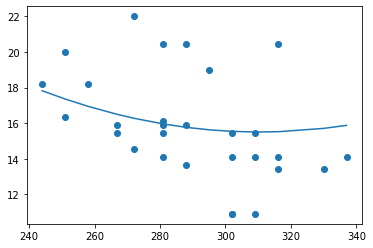

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### Çeşitlerin Kodlanması

İdeal bir dünyada, farklı balkabağı çeşitleri için fiyatları aynı modelle tahmin edebilmek isteriz. Çeşidi hesaba katmak için, önce onu sayısal bir forma dönüştürmemiz, yani **kodlamamız** gerekir. Bunu yapmanın birkaç yolu vardır:

* Basit sayısal kodlama, farklı çeşitlerin bir tablosunu oluşturur ve ardından çeşit adını bu tablodaki bir indeksle değiştirir. Bu, doğrusal regresyon için en iyi fikir değildir, çünkü doğrusal regresyon indeksin sayısal değerini dikkate alır ve bu sayısal değer muhtemelen fiyatla sayısal olarak ilişki kurmaz.
* Tekil kodlama (one-hot encoding), `Variety` sütununu 4 farklı sütunla değiştirir. Her sütun, ilgili satırın belirli bir çeşide ait olup olmadığını göstermek için 1 veya 0 içerir.

Aşağıdaki kod, bir çeşidi nasıl tekil kodlayabileceğimizi gösteriyor:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### Çeşit Üzerinde Doğrusal Regresyon

Şimdi yukarıdakiyle aynı kodu kullanacağız, ancak `DayOfYear` yerine giriş olarak tek-seçenekli kodlanmış çeşidimizi kullanacağız:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


Aynı şekilde diğer özellikleri kullanmayı deneyebilir ve bunları `Month` veya `DayOfYear` gibi sayısal özelliklerle birleştirebiliriz:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### Polinom Regresyon

Polinom regresyon, tekil sıcak kodlanmış kategorik özelliklerle de kullanılabilir. Polinom regresyonu eğitmek için kullanılan kod, yukarıda gördüğümüzle temelde aynı olacaktır.


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**Feragatname**:  
Bu belge, [Co-op Translator](https://github.com/Azure/co-op-translator) adlı yapay zeka çeviri hizmeti kullanılarak çevrilmiştir. Doğruluk için çaba göstersek de, otomatik çevirilerin hata veya yanlışlıklar içerebileceğini lütfen unutmayın. Orijinal belgenin kendi dilindeki hali yetkili kaynak olarak kabul edilmelidir. Kritik bilgiler için profesyonel insan çevirisi önerilir. Bu çevirinin kullanımından kaynaklanan herhangi bir yanlış anlama veya yanlış yorumlama durumunda sorumluluk kabul edilmez.
